In [1]:
import requests
import json
import time
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv

# API Calls
The following functions ("mag_evaluate", "mag_evaluate_title" and "mag_evaluate_id") are simple wrappers around the [Microsoft Academic Graph](https://www.microsoft.com/en-us/research/project/microsoft-academic-graph/) API. From here on, we will abbreviate "Microsoft Academic Graph" as "MAG". The API documentation can be found [here](https://docs.microsoft.com/en-us/azure/cognitive-services/academic-knowledge/home) and [here](https://dev.labs.cognitive.microsoft.com/docs/services/56332331778daf02acc0a50b/operations/565d9001ca73072048922d97).

In [12]:
def mag_evaluate(query, wait_time=10):
    try:
        response = requests.get(
            url="http://api.labs.cognitive.microsoft.com/academic/v1.0/evaluate",
            params={
                "expr": query,
                "model": "latest",
                "count": "10",
                "offset": "0",
                #"orderby": "null",
                "attributes": "Id,Ty,Ti,L,Y,D,CC,ECC,AA.AuN,AA.AuId,AA.AfN,AA.AfId,AA.S,F,J,C,RId,W,E",
            },
            headers={
                "Ocp-Apim-Subscription-Key": "1c99573804ad445dac00b28fdbafbea3",
                "subscription-key": "",
            },
        )
        
        if response.status_code == 429:
            print("Rate limited: waiting {} seconds".format(wait_time))
            time.sleep(wait_time)
            return mag_evaluate(query, wait_time/2)
        wait_time = 1
        
        print('Response HTTP Status Code: {status_code}'.format(
            status_code=response.status_code))
        
        resp = json.loads(response.content)
        if 'entities' in resp:
            for obj in resp['entities']:
                obj.pop('E', None)
            return resp['entities']
        else:
            return resp
    except requests.exceptions.RequestException:
        print('HTTP Request failed')
        return None

def mag_evaluate_title(title):
    title = "".join(filter(lambda x: x.isdigit() | x.isalpha() | x.isspace(), title.lower()))
    print(title)
    return mag_evaluate("Ti=\'{}\'".format(title))
    
def mag_evaluate_id(mag_id):
    return mag_evaluate("Id={}".format(mag_id))[0]

# Example Request
The following cell is an example of a query for a paper, showing all the data that the MAG has on a given paper.

In [3]:
obj = mag_evaluate_title('Sex Differences in Spatial Cognition, Computational Fluency, and Arithmetical Reasoning')[0]
obj

sex differences in spatial cognition computational fluency and arithmetical reasoning
Response HTTP Status Code: 200


{'AA': [{'AfId': 76835614,
   'AfN': 'university of missouri',
   'AuId': 2139735668,
   'AuN': 'david c geary',
   'S': 1},
  {'AfId': 76835614,
   'AfN': 'university of missouri',
   'AuId': 2332559390,
   'AuN': 'scott j saults',
   'S': 2},
  {'AfId': 76835614,
   'AfN': 'university of missouri',
   'AuId': 2638115031,
   'AuN': 'fan liu',
   'S': 3},
  {'AfId': 76835614,
   'AfN': 'university of missouri',
   'AuId': 1884467649,
   'AuN': 'mary k hoard',
   'S': 4}],
 'CC': 299,
 'D': '2000-01-12',
 'ECC': 299,
 'Id': 2027732696,
 'L': 'en',
 'RId': [2037124948,
  2107031757,
  2149608872,
  1557941956,
  2068891585,
  2076192758,
  2162397375,
  1981402013,
  1965775807,
  2084945517,
  1520561658,
  2065343501,
  1658590135,
  2165565225,
  2030739764,
  1999464409,
  116335470,
  1998516725,
  1977183314,
  2034434948,
  2115208512,
  2019185700,
  2121510194,
  2143908714,
  2023592088,
  2166291487,
  1988891699,
  1970545861,
  2333184519,
  2041017323,
  2076833019,
  20786

# Graph Collection Functions
These functions together map the data from the MAG to a networkx graph for analysis. 

add_paper_node adds a paper as a node to the networkx graph structure with its Id field being the node key and all the opther attributes saved along with the node.

add_citation_edge links two papers together by adding an edge between their two Ids.

add_paper_with_citations is the function that crawls the MAG looking for papers. It is a recursive function that walks from a root paper, to the papers that it cites, and so on. This is limited by a "depth" counter that limits the function to a certain degree of separation.

In [4]:
def add_paper_node(graph, paper):
    graph.add_node(paper['Id'], **paper)

def get_paper_from_node(graph, paper_id):
    return graph.node[paper_id]

def add_citation_edge(graph, paper, cited_paper):
    graph.add_edge(paper['Id'], cited_paper['Id'])
    
def add_paper_with_citations(graph, paper, depth=0):
    try:
        graph.node[paper['Id']]
    except KeyError:
        add_paper_node(graph, paper)
    try:
        for cited_paper_id in paper['RId']:
            if not graph.has_node(cited_paper_id):
                cited_paper = mag_evaluate_id(cited_paper_id)
                add_paper_node(graph, cited_paper)
            
            graph.add_edge(paper['Id'], cited_paper_id)
            if depth > 1:
                add_paper_with_citations(graph, graph.node[cited_paper_id], depth-1)
    except KeyError:
        return
        

In [5]:
testGraph = nx.DiGraph()
paper = mag_evaluate_id(2027732696)
add_paper_node(testGraph, paper)
testGraph.node[2027732696] == paper

Response HTTP Status Code: 200


True

In [11]:
G1 = nx.DiGraph()
add_paper_with_citations(G1, mag_evaluate("Ti == 'sex linked inheritance of spatial ability'")[0], 10)

Rate limited: waiting 10 seconds
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200


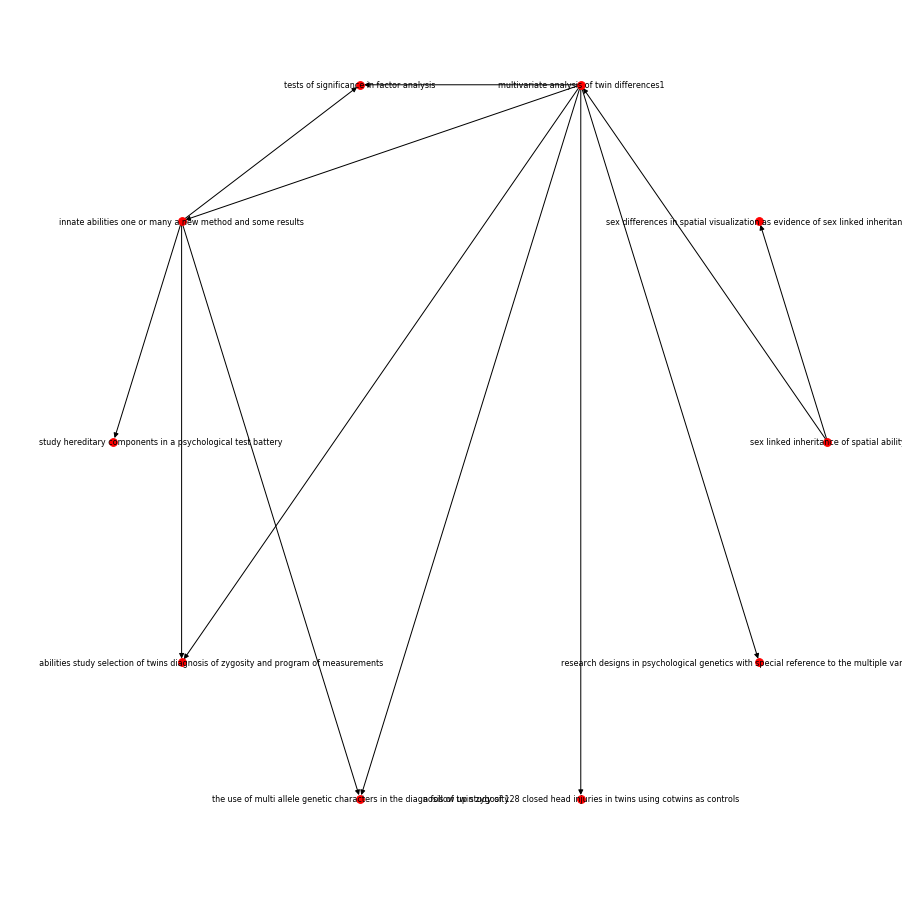

In [13]:
plt.figure(2, figsize=(12,12))

layout = nx.shell_layout(G1)
nx.draw(G1,layout,node_size=60,font_size=8) 

nx.draw_networkx_labels(G1,pos=layout,labels=nx.get_node_attributes(G1,'Ti'), font_size=8)
plt.show()

In [29]:
G2 = nx.DiGraph()
add_paper_with_citations(G2, mag_evaluate_title('Sex Differences in Spatial Cognition, Computational Fluency, and Arithmetical Reasoning')[0], 1)
nx.write_gpickle(G2, "g2.gpickle")

sex differences in spatial cognition computational fluency and arithmetical reasoning
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Rate limited: waiting 10 seconds
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Rate limited: waiting 10 seconds
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HT

In [13]:
G3 = nx.DiGraph()
add_paper_with_citations(G3, mag_evaluate_title('Sex Differences in Spatial Cognition, Computational Fluency, and Arithmetical Reasoning')[0], 2)
nx.write_gpickle(G3, "g3.gpickle")

sex differences in spatial cognition computational fluency and arithmetical reasoning
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Rate limited: waiting 10 seconds
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Rate limited: waiting 10 seconds
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HTTP Status Code: 200
Response HT

In [28]:
G2 = nx.read_gpickle("g2.gpickle")
G3 = nx.read_gpickle("g3.gpickle")

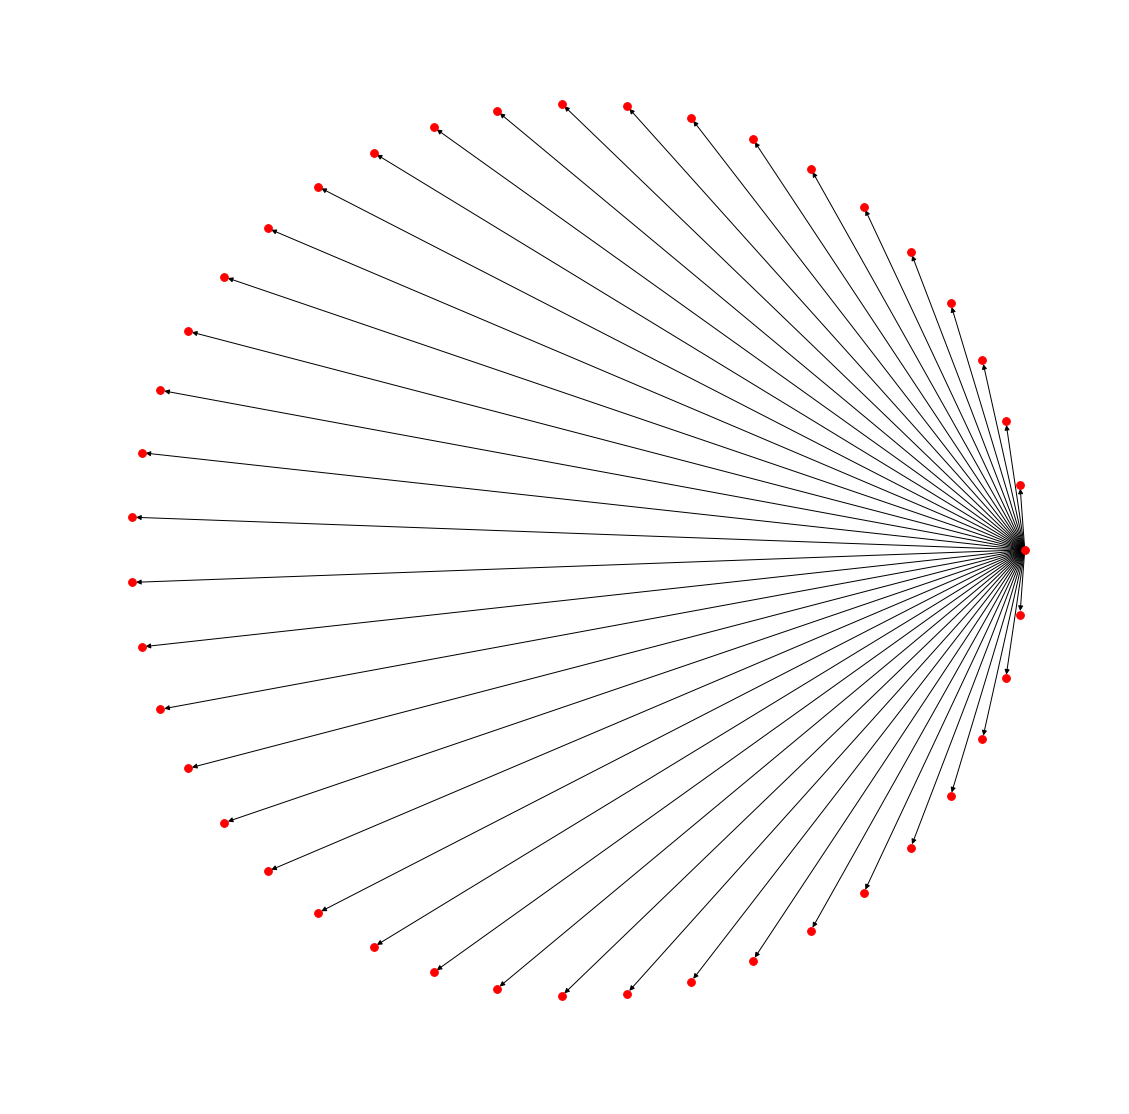

In [45]:
plt.figure(1, figsize=(15,15))

layout = nx.shell_layout(G2)
nx.draw(G2,layout,node_size=60,font_size=8) 

#nx.draw_networkx_labels(G2,pos=layout)
#nx.draw_networkx_labels(G2,pos=layout,labels=nx.get_node_attributes(G2,'Ti'), font_size=10)
plt.savefig('fig1.png')
plt.show()

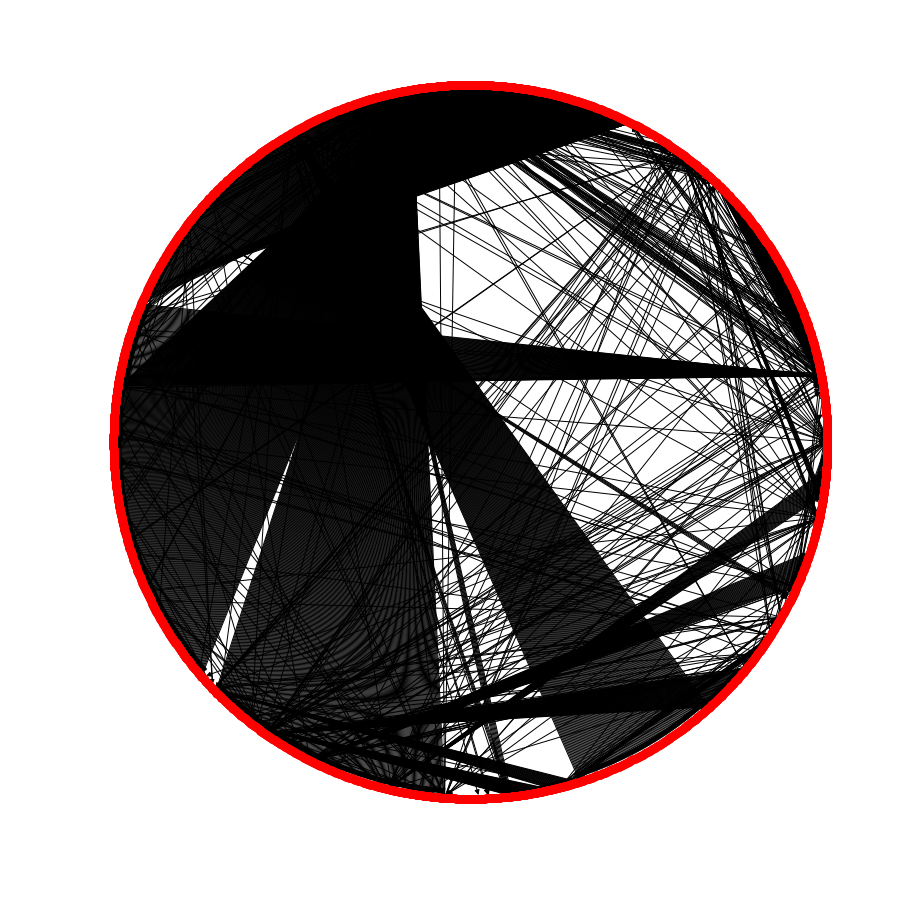

In [43]:
plt.figure(1, figsize=(12,12))

layout = nx.shell_layout(G3)
nx.draw(G3,layout,node_size=60,font_size=8) 

#nx.draw_networkx_labels(G3,pos=layout, font_size=8)
#nx.draw_networkx_labels(G2,pos=layout,labels=nx.get_node_attributes(G2,'Ti'), font_size=8)
plt.savefig('fig2.png')
plt.show()

In [27]:
G2.size()

NameError: name 'G2' is not defined